In [1]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from imutils import face_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imutils
import time
import dlib
import cv2

%matplotlib inline

In [2]:
#blink detection: https://github.com/rishikksh20/Liveness-Detection/blob/master/detect_blinks.py

#seems we're using ./build/bin/FeatureExtraction -f ~/projects/behAV_example/jimcarrey.mp4 -out_dir ~/projects/behAV_example/data -of jimcarrey_of

#Patrick's script:
#concat gopro vids first
#> ls *.MP4 | sed "s/^/file '/g; s/$/'/g" > filelist.txt
#> ffmpeg -f concat -safe 0 -i filelist.txt -c copy video.mp4
#OpenFace to output only csv file (saves space and time)
#> FeatureExtraction.exe -f "E:\data_cap_val_2\patrick_1\GoPro\video.mp4" -2Dfp -3Dfp -pdmparams -pose -aus -gaze

In [2]:
video_filename = 'vid_analysis/jim_1080p_1m39.mp4'

Example Code to Stream video with blink detector running

In [3]:
def eye_aspect_ratio(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])

    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[3])

    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)

    # return the eye aspect ratio
    return ear

def example_stream_blink_detector(video_filename, thresh=0.00325, consec_frames=3, resize_width=None):
    
    COUNTER = 0
    TOTAL = 0
    WINDOW_NAME = 'blink_window'
    
    # initialize dlib's face detector (HOG-based) and then create
    # the facial landmark predictor
    print("[INFO] loading facial landmark predictor...")
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    # start the video stream thread
    print("[INFO] starting video stream thread...")
    vs = FileVideoStream(video_filename).start()
    
    cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_AUTOSIZE)
    cv2.startWindowThread()

    time.sleep(1.0)

    # loop over frames from the video stream
    while True:
        
        frame = vs.read()
        if frame is None: break

        if resize_width is not None: frame = imutils.resize(frame, width=resize_width)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # detect faces in the grayscale frame
        rects = detector(gray, 0)

        # loop over the face detections
        for rect in rects:
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x, y)-coordinates to a NumPy
            # array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)

            # extract the left and right eye coordinates, then use the
            # coordinates to compute the eye aspect ratio for both eyes
            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)

            # average the eye aspect ratio together for both eyes
            ear = (leftEAR + rightEAR) / 2.0
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            ear_ratio = ear/w
            # compute the convex hull for the left and right eye, then
            # visualize each of the eyes
            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
            cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

            # check to see if the eye aspect ratio is below the blink
            # threshold, and if so, increment the blink frame counter
            if ear_ratio < thresh:
                COUNTER += 1
            else:
                if COUNTER >= consec_frames:
                    TOTAL += 1

                COUNTER = 0

            # draw the total number of blinks on the frame along with
            # the computed eye aspect ratio for the frame
            cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, "EAR: {:.5f}".format(ear), (300, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # show the frame
        cv2.imshow(WINDOW_NAME, frame)
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

    # do a bit of cleanup
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    vs.stop()

In [11]:
example_stream_blink_detector(video_filename, resize_width=720)

[INFO] loading facial landmark predictor...
[INFO] starting video stream thread...


Now we write code to analyze the video for the eye aspect ratio and save it to a CSV without streaming
the video to the screen.  We can then analyze what threshold works the best (testing several, since we
know people typically blink ~15 times a min), and then apply that threshold and stream the video with
a blink indicator overlaid, just to make sure it's working the way we were hoping/intending.

In [ ]:
def expected_blinks(duration_min):
    print('we expect about', duration_min*15,'blinks in this period.')

    
#returns pd.dataframe with eye aspect ratio/timestamp for each frame and FPS
#no face recognition give NaN for eye detector
def analyze_video_for_blinks(video_filename, csv_name=None, resize_width=720):
    
    frame_data = {}
    counter = 0
    
    print("[INFO] loading facial landmark predictor...")
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    # grab the indexes of the facial landmarks for the left and
    # right eye, respectively
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    # start the video stream thread
    print("[INFO] starting video stream thread...")
    vs = cv2.VideoCapture(video_filename)
    
    total_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = vs.get(cv2.CAP_PROP_FPS)
    print('FPS:',fps,'\tTotal Frames:',total_frames,'\tDuration (s):',total_frames/fps)   

    eye_ratio_data = pd.DataFrame()
    
    time.sleep(1.0)
    
    # loop over frames from the video stream
    for fno in range(0, total_frames):
        
        if not fno % (fps*30): print('%8d frames processed (%3.2f min)' % (fno, fno/fps/60))
            
        _, frame = vs.read()
        frame = imutils.resize(frame, width=resize_width)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        frame_data['timestamp'] = vs.get(cv2.CAP_PROP_POS_MSEC)
        frame_data['eye_ratio'] = np.nan
        
        # detect faces in the grayscale frame
        rects = detector(gray, 0)
                
        # loop over any face detections
        for rect in rects:
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x, y)-coordinates to a NumPy
            # array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)

            # extract the left and right eye coordinates, then use the
            # coordinates to compute the eye aspect ratio for both eyes
            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)

            # average the eye aspect ratio together for both eyes
            ear = (leftEAR + rightEAR) / 2.0
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            ear_ratio = ear/w
            
            if np.isnan(frame_data['eye_ratio']): frame_data['eye_ratio'] = ear_ratio
            elif ear_ratio < frame_data['eye_ratio']: frame_data['eye_ratio'] = ear_ratio
                
        eye_ratio_data = eye_ratio_data.append(frame_data, ignore_index=True)

    print('[INFO] completed blink analysis.')
    
    if csv_name is not None: 
        print('[INFO] saving to', csv_name)
        eye_ratio_data.to_csv(csv_name)
        
    return eye_ratio_data, fps
   
#stream the video with blink annotations
def stream_with_blink_data_overlay(video_filename, ratio_data, resize_width=720):
    if 'blink_signal' not in ratio_data.columns:
        print('ERROR: must pass a pandas dataframe that already has' + \
                'a blink signal calculated, use add_blink_signal_to_dataframe')
        return
    
    blink_data = ratio_data['blink_signal'].tolist()
    
    WINDOW_NAME = 'blink_window'
    cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_AUTOSIZE)
    cv2.startWindowThread()

    vs = FileVideoStream(video_filename).start()
    time.sleep(1.0)
    
    for fno in range(0, len(blink_data)):
        frame = vs.read()  
        frame = imutils.resize(frame, width=resize_width)
    
        if blink_data[fno] and not np.isnan(blink_data[fno]):
            cv2.putText(frame, "BLINKING NOW!!!!!!", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
       
        # show the frame
        cv2.imshow(WINDOW_NAME, frame)
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

    # do a bit of cleanup
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    vs.stop()

In [8]:
ratio_data, fps = analyze_video_for_blinks(video_filename, 'vid_analysis/test_eyeratio.csv')

[INFO] loading facial landmark predictor...
[INFO] starting video stream thread...
FPS: 30.0 	Total Frames: 2994 	Duration (s): 99.8
       0 frames processed (0.00 min)


NameError: name 'eye_aspect_ratio' is not defined

In [14]:
ratio_data.head()

,eye_ratio,timestamp
0,NaN,0.000000
1,NaN,33.333333
2,NaN,66.666667
3,NaN,100.000000
4,NaN,133.333333


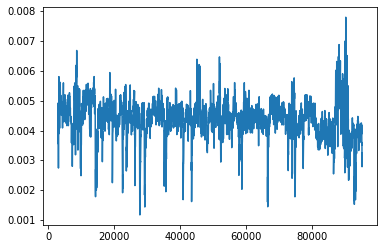

In [15]:
plt.plot(ratio_data.timestamp, ratio_data.eye_ratio)
plt.show()

In [ ]:
def suggest_blink_thresh(ratio_data, thresh_ms=100, thresh_range=[.0015,.0045], fps=60, steps=20):
    #pull data that actually has detections
    ratio_data_real = ratio_data.dropna()
    blink_data = ratio_data_real['eye_ratio'].tolist()
    
    best_thresh, distance= None, np.inf
    #check how many blinks we expect
    duration_face_recognized_min = len(blink_data)/(fps*60.)
    expected_num_blinks = duration_face_recognized_min * 15 #roughly 15 per min
    print('expected %.1f blinks over %.2f min of identified face.' % (expected_num_blinks, duration_face_recognized_min))
    print('-------------------------------------')
    
    #calc num blinks
    for thresh in np.linspace(thresh_range[0], thresh_range[1], steps):
        blink_count, thresh_count = 0, 0
        for val in blink_data:
            if val < thresh: thresh_count += 1
            else: thresh_count = 0
            if thresh_count == int(fps*(thresh_ms/1000.)): blink_count +=1 
        
        if abs(blink_count-expected_num_blinks) <= distance:
            distance = abs(blink_count-expected_num_blinks)
            best_thresh = thresh
            
        print('thresh = %2.4f, %5d blinks detected.' % (thresh, blink_count))
        
    return best_thresh

def add_blink_signal_to_dataframe(ratio_data, thresh, thresh_ms=100, fps=60):
    new_col = []
    thresh_count = 0
              
    for val in ratio_data['eye_ratio']:
        if 0 < val < thresh: 
              thresh_count += 1
        else:
            #handle previous potential blink if we've just finished counting
            if thresh_count >= fps*(thresh_ms/1000.):
                new_col.extend([1]*(thresh_count))
            else:
                new_col.extend([0]*(thresh_count))     
            
            #add the value for current data
            if np.isnan(val): new_col.append(np.nan)
            else: new_col.append(0)     
              
            thresh_count = 0
    
    if thresh_count >= fps*(thresh_ms/1000.):
        new_col.extend([1]*(thresh_count))
    else:
        new_col.extend([0]*(thresh_count)) 
              
    ratio_data['blink_signal'] = new_col
    return ratio_data
              
def plot_blink_signal(ratio_data):
    if 'blink_signal' not in ratio_data.columns:
        print('ERROR: must pass a pandas dataframe that already has' + \
                'a blink signal calculated, use add_blink_signal_to_dataframe')
        return
              
    plt.plot(ratio_data.timestamp, ratio_data.eye_ratio)
    plt.plot(ratio_data.timestamp, ratio_data.blink_signal*ratio_data.eye_ratio.max())
    plt.show()

In [7]:
best_thresh = suggest_blink_thresh(ratio_data, fps=30)
print('\nBEST THRESHOLD: ',best_thresh,'\n')

ratio_data_w_blink = add_blink_signal_to_dataframe(ratio_data, best_thresh, fps=30)
plot_blink_signal(ratio_data_w_blink)

NameError: name 'ratio_data' is not defined

In [20]:
stream_with_blink_data_overlay(video_filename, ratio_data_w_blink)

[INFO] starting video stream thread...


So all the above works (we can analyze the video, then find a good threshold, then apply that to get a 0/1
indicator for blinking, then stream it back to check it worked well).

Let's just double check that the original csv we saved will load in and work exactly as expected.

In [ ]:
#double check we can load the csv and use as normal

double_check = pd.read_csv('vid_analysis/test_eyeratio.csv')
best_thresh = suggest_blink_thresh(double_check, fps=30)
print('\nBEST THRESHOLD: ',best_thresh,'\n')

dc_w_blink = add_blink_signal_to_dataframe(double_check, best_thresh, fps=30)
plot_blink_signal(dc_w_blink)

expected 23.1 blinks over 1.54 min of identified face.
-------------------------------------
thresh = 0.0015,     1 blinks detected.
thresh = 0.0017,     1 blinks detected.
thresh = 0.0018,     2 blinks detected.
thresh = 0.0020,     2 blinks detected.
thresh = 0.0021,     3 blinks detected.
thresh = 0.0023,     6 blinks detected.
thresh = 0.0024,     8 blinks detected.
thresh = 0.0026,    11 blinks detected.
thresh = 0.0028,    14 blinks detected.
thresh = 0.0029,    16 blinks detected.
thresh = 0.0031,    19 blinks detected.
thresh = 0.0032,    24 blinks detected.
thresh = 0.0034,    27 blinks detected.
thresh = 0.0036,    35 blinks detected.
thresh = 0.0037,    43 blinks detected.
thresh = 0.0039,    49 blinks detected.
thresh = 0.0040,    61 blinks detected.
thresh = 0.0042,    85 blinks detected.
thresh = 0.0043,   100 blinks detected.
thresh = 0.0045,   133 blinks detected.

BEST THRESHOLD:  0.0032368421052631578 



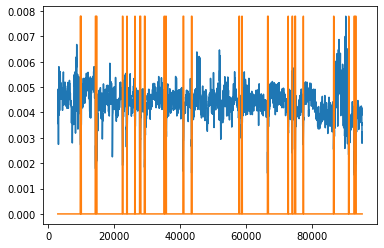

In [7]:
#double check we can load the csv generated by run_blink_extractor.py and use as normal

double_check = pd.read_csv('vid_analysis/jim_1080p_1m39_eyeratio.csv')
best_thresh = suggest_blink_thresh(double_check, fps=30)
print('\nBEST THRESHOLD: ',best_thresh,'\n')

dc_w_blink = add_blink_signal_to_dataframe(double_check, best_thresh, fps=30)
plot_blink_signal(dc_w_blink)

In [ ]:
#double check our multi-threaded version gives the same exact data

double_check_2 = pd.read_csv('vid_analysis/jim_1080p_1m39_eyeratio.csv')
best_thresh = suggest_blink_thresh(double_check_2, fps=30)
print('\nBEST THRESHOLD: ',best_thresh,'\n')

dc_w_blink = add_blink_signal_to_dataframe(double_check_2, best_thresh, fps=30)
plot_blink_signal(dc_w_blink)

print(len(double_check))
print(len(double_check_2))
print(double_check.head())
print(double_check_2.head())

print(double_check.tail())
print(double_check_2.tail())

